<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-351 Neurocomputação**

**Professor:**
*Dr. Marcos Goncalves Quiles*

**Aluno:**
*Lourenço José Cavalcante Neto*

---

**PROPOSTA DE PROJETO 1: Experimentos com a rede Multi-layer Perceptron (MLP)**

**Descrição do projeto:**

1. Selecionar dois datasets (não triviais): Um dataset para classificação; Um dataset para regressão; Separar em treino/validação/teste.

2. Treinar modelos MLP para os dois problemas (**classificação** e **regressão**)

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

O presente material pode ser acessado no **github**: 

# Bibliotecas/Pacotes

In [29]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import datetime

from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.8.2


# Dataset
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície. No total, o Dataset possui 06 atributos, os são listados abaixo:

```
Datetime
Rain Intensity (mm/h)
radar reflectivity (1/mm6m3)
Liquid watercontent (g/m3)
Mean weight diameter(mm)
Time integration (s)
```

*Ob.: Conforme sugerido/autorizado pelo professor Marcos na aula do dia 11/07, o mesmo Dataset será utilizado para os problemas de Classificação e Regressão.*

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [159]:
#Importando o Dataset e criando o Dataframe
df_rd80_full = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_full = pd.DataFrame(df_rd80_full)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_full.shape[0], ', quantidade de atributos: ', df_rd80_full.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


Como podemos ver, o tamanho do nosso Dataset é de 315.420 e isso pode ocasionar um custo computacional muito alto durante os experimentos e testes do Projeto. Sendo assim, será utilizado apenas 1/3 dos dados.

In [160]:
#Definindo uma parte do Dataset para usá-lo neste Projeto
limit_date = datetime.datetime(year=2022, month=4,day=1)

df_rd80_full = df_rd80_full.set_index('Datetime')

df_rd80 = df_rd80_full.loc[df_rd80_full.index >= str(limit_date)]
#df_rd80 = df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0]
df_rd80.reset_index(inplace=True)

print('Tamanho do Dataset que será utilizado: ', df_rd80.shape[0])


Tamanho do Dataset que será utilizado:  120881


In [161]:
#Carregando o Dataset
df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0].head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
906,2022-04-01 15:06:00,0.43260,38.06263,0.03692,0.79742,60.0
907,2022-04-01 15:07:00,0.41725,27.16787,0.04383,0.64697,60.0
914,2022-04-01 15:14:00,1.17214,584.40277,0.05541,1.72444,60.0
915,2022-04-01 15:15:00,5.79155,2041.65967,0.30273,1.47975,60.0
916,2022-04-01 15:16:00,5.42038,1292.17163,0.32774,1.21349,60.0


In [ ]:
#Normalizando os dados
#É necessário assumir que os valores para Rain Intensity (mm/h) que forem menores que 0.1 sejam considerados como 0(zero)
df_rd80['Rain Intensity (mm/h)'].loc[df_rd80['Rain Intensity (mm/h)'] < 0.1] = 0

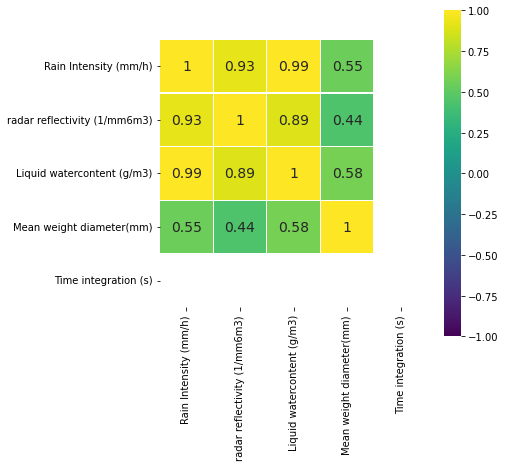

In [163]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

[]

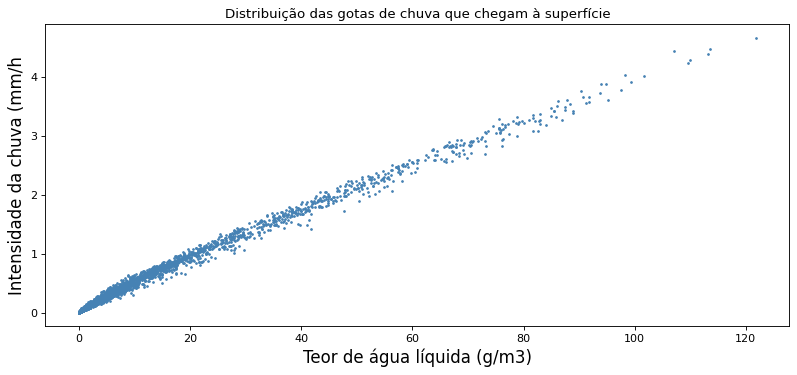

In [170]:
figure(figsize=(12,5),dpi=80)
plt.scatter(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'],s=2, color='#4682B4')
plt.xlabel(r'Teor de água líquida (g/m3)',size=15)
plt.ylabel(r'Intensidade da chuva (mm/h)',size=15)
plt.title("Distribuição das gotas de chuva que chegam à superfície")
plt.plot()

Conforme orientações para o projeto, para realizar o treinamento e validação do aprendizado de uma rede **Multi-layer Perceptron (MLP)**, realizou-se a divisão do conjunto de dados em dois grupos: Treino (70%) e Teste (30%). A biblioteca scikit-learn nos auxilia nesta tarefa. 

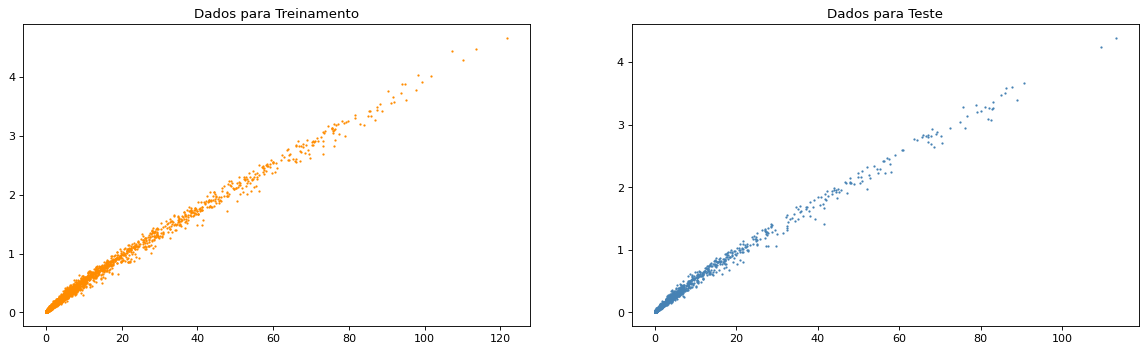

Tamanho do dataset para treinamento:  84616
Tamanho do dataset para validação:  36265


In [167]:
# Divisão do Dataset em treinamento e validação

x_train, x_test, y_train, y_test = train_test_split(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Liquid watercontent (g/m3)'], test_size=.30)

figure(figsize=(18,5),dpi=80)

plt.subplot(1,2,1)
plt.title('Dados para Treinamento')
plt.scatter(x_train, y_train, color='#FF8C00',s=1)

plt.subplot(1,2,2)
plt.title('Dados para Teste')
plt.scatter(x_test, y_test, color='#4682B4',s=1)
plt.show()


print('Tamanho do dataset para treinamento: ',len(x_train))
print('Tamanho do dataset para validação: ',len(x_test))

# **PROBLEMA 1: Regressão**
Com o objetivo de construir uma rede capaz de encontrar uma lei de regressão para o problema, serão criadas 06(seis) topologias de rede diferentes. Onde o primeiro será o caso simples e clássico de um perceptron e a partir do segundo será modificado o número de camadas e o número de neurônios.

## **Topologia I**
Este primeiro será um caso simples e clássico de um perceptron.




**Criação dos modelos**

In [186]:
#Configurações para avaliar o impacto do uso do Momentum e da Regularização (L2)
momentum = [0.0, 0.20, 0.0, 0.60]
regularizer = [0.0, 0.15, 0.20, 0.0]
dropout = [0.0, 0.0, 0.0, 0.0]

#Modelos da Topologia I
list_name_aux =[1,2,3,4]
modelos_tpl_I = []

for result in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.0)
  modelos_tpl_I.append(keras.Sequential())
  modelos_tpl_I[result].add(keras.layers.Dense(units=3, kernel_regularizer=l2(regularizer[result]), input_shape=[1], activation="tanh"))
  modelos_tpl_I[result].add(keras.layers.Dense(units=1, kernel_regularizer=l2(regularizer[result]),activation="linear"))
  #tf.keras.utils.plot_model(modelos_tpl_I[result], show_shapes=True)
  modelos_tpl_I[result].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [185]:
epochs = 5 #Define a quantidade de épocas para o treinamento
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)


history_modelos_tpl_I = []
for result in range(0,4):
  history_modelos_tpl_I.append(modelos_tpl_I[result].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


Epoch 1/5
6770/6770 [==============================] - 22s 3ms/step - loss: 0.0442 - mean_absolute_error: 0.0296 - val_loss: 0.0243 - val_mean_absolute_error: 0.0276
Epoch 2/5
6770/6770 [==============================] - 22s 3ms/step - loss: 0.0240 - mean_absolute_error: 0.0303 - val_loss: 0.0237 - val_mean_absolute_error: 0.0312
Epoch 3/5
6770/6770 [==============================] - 22s 3ms/step - loss: 0.0237 - mean_absolute_error: 0.0297 - val_loss: 0.0234 - val_mean_absolute_error: 0.0290
Epoch 4/5
6770/6770 [==============================] - 22s 3ms/step - loss: 0.0235 - mean_absolute_error: 0.0291 - val_loss: 0.0233 - val_mean_absolute_error: 0.0294
Epoch 5/5
6770/6770 [==============================] - 22s 3ms/step - loss: 0.0232 - mean_absolute_error: 0.0288 - val_loss: 0.0230 - val_mean_absolute_error: 0.0284
Epoch 1/5
6770/6770 [==============================] - 21s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0248 - val_loss: 0.0047 - val_mean_absolute_error: 0.0135
Epoc

**Resultados do Treinamento**

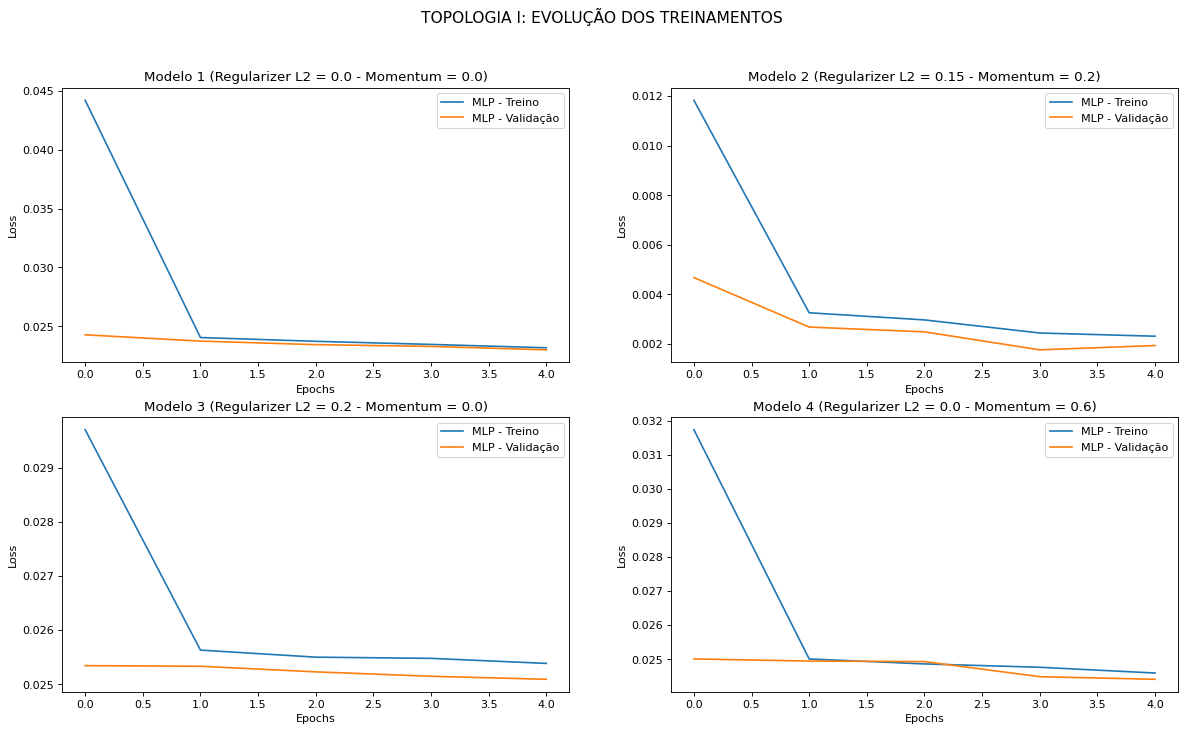

In [193]:
figure(figsize=(18,10),dpi=80)
plt.suptitle('TOPOLOGIA I: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for result in range(0,4):
    plt.subplot(2,2,result+1)
    plt.title('Modelo '+ str(result+1) + ' (Regularizer L2 = '+str(regularizer[result])+' - Momentum = '+str(momentum[result])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_modelos_tpl_I[result].history['loss'], label="MLP - Treino")
    plt.plot(history_modelos_tpl_I[result].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

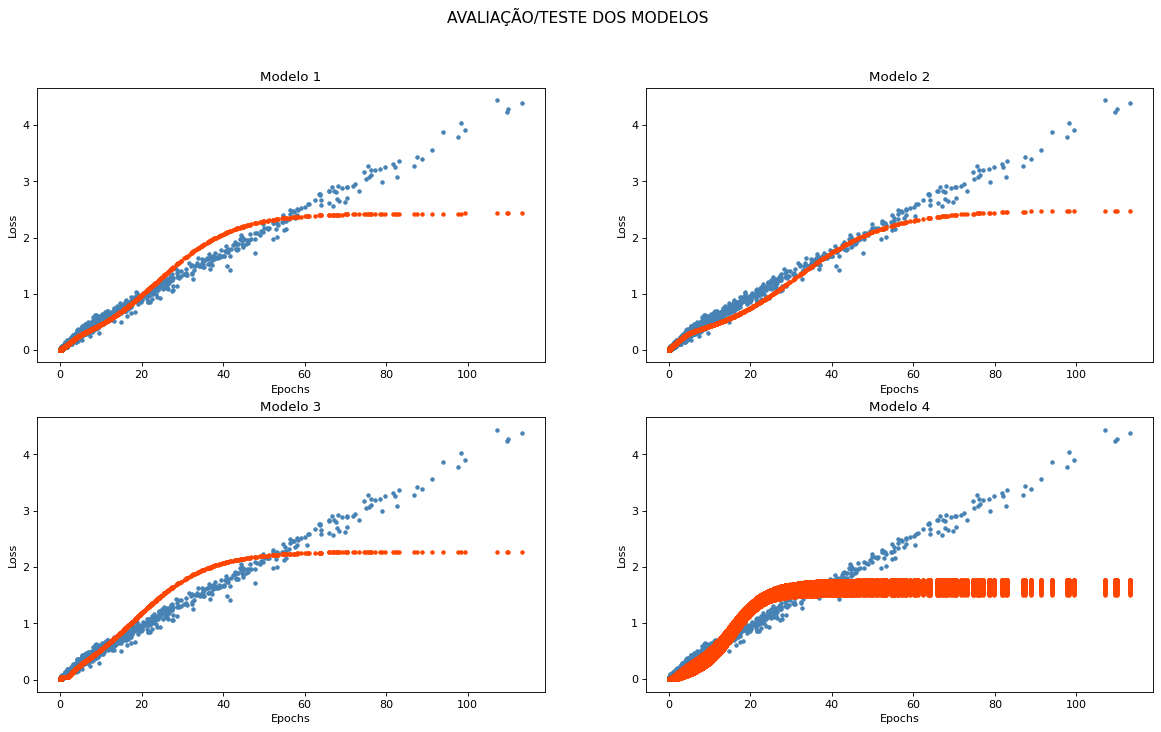

In [165]:
figure(figsize=(18,10),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS', size=14)

for m, res_modelo in zip(range(0, len(lista_modelos)), lista_modelos):

  plt.subplot(2,2,m+1)
  y_rest = res_modelo.predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(m+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

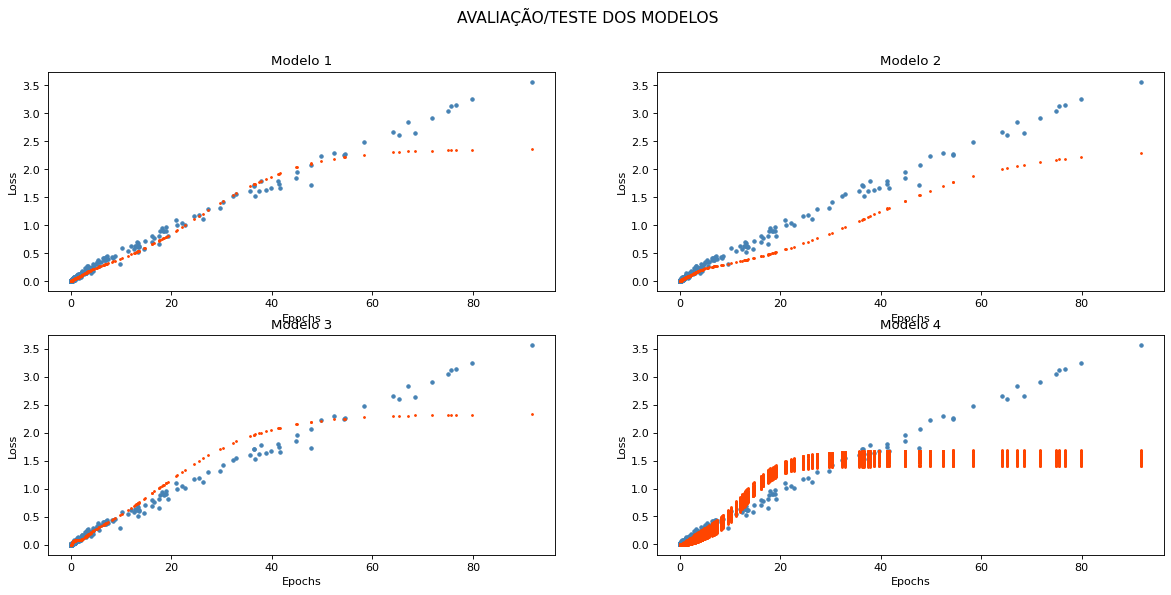

343/343 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0079


In [96]:
figure(figsize=(18,8),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS', size=14)
for m, res_modelo in zip(range(0, len(lista_modelos)), lista_modelos):

  plt.subplot(2,2,m+1)
  y_rest = res_modelo.predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(m+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()



test_loss = modelo_a.evaluate(x_test, y_test)
test_loss = modelo_b.evaluate(x_test, y_test)
test_loss = modelo_c.evaluate(x_test, y_test)
test_loss = modelo_final.evaluate(x_test, y_test)

In [98]:
score_modelo_a = modelo_a.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_a[0])
print("Teste metric:", score_modelo_a[1])
print("\n")
score_modelo_b = modelo_b.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_b[0])
print("Teste metric:", score_modelo_b[1])
print("\n")
score_modelo_c = modelo_c.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_modelo_c[0])
print("Teste metric:", score_modelo_c[1])
print("\n")
score_model_final = modelo_final.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score_model_final[0])
print("Teste metric:", score_model_final[1])

Teste loss: 0.000573305762372911
Teste metric: 0.0019788986537605524


Teste loss: 0.0016939167398959398
Teste metric: 0.004098472185432911


Teste loss: 0.0008318467880599201
Teste metric: 0.002676192205399275


Teste loss: 0.002763406140729785
Teste metric: 0.007940475828945637




---



## **Topologia B**

In [ ]:
momentum = [0.0, 0.15, 0.0, 0.6]
regularizer = [0.15, 0.0, 0.0, 0.2]
dropout = [0.2, 0.0, 0.25, 0.0]

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.0)
adam = tf.keras.optimizers.Adam()

#modelo_a
modelo_a = keras.Sequential()
modelo_a.add(keras.layers.Dense(units=3, input_shape=[1], activation="tanh"))
modelo_a.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_a, show_shapes=True)

#modelo_b
modelo_b = keras.Sequential()
modelo_b.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_b.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_b.add(keras.layers.Dense(units=1, activation="tanh"))
#tf.keras.utils.plot_model(modelo_b, show_shapes=True)

#modelo_c
modelo_c = keras.Sequential()
modelo_c.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_c.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_c.add(keras.layers.Dense(units=1, activation="tanh"))
#tf.keras.utils.plot_model(modelo_c, show_shapes=True)

#modelo_final
modelo_final = keras.Sequential()
modelo_final.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=40, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(Dropout(drop))
modelo_final.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="tanh"))
modelo_final.add(keras.layers.Dense(units=1, activation="linear"))
tf.keras.utils.plot_model(modelo_final, show_shapes=True)

In [ ]:
modelo_b.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_c.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_final.compile(loss='mean_squared_error', optimizer=sgd_momentum_060, metrics=["mean_absolute_error"])

lista_modelos = [modelo_a, modelo_b, modelo_c, modelo_final]

# Problema 2: Classificação

In [ ]:
#Vamos coletar apenas uma parte do Dataset para usá-lo neste Projeto
split_date = datetime.datetime(year=2022, month=6,day=1)

df_train_rd80 = df_rd80.loc[df_rd80.index < str(split_date)]
df_val_rd80 = df_rd80.loc[df_rd80.index >= str(split_date)]

df_train_rd80.reset_index(inplace=True)
df_val_rd80.reset_index(inplace=True)

print('Shape do treinamento: ', df_train_rd80.shape)
print('Shape da validação: ', df_val_rd80.shape)
df_train_rd80.head(n=20)

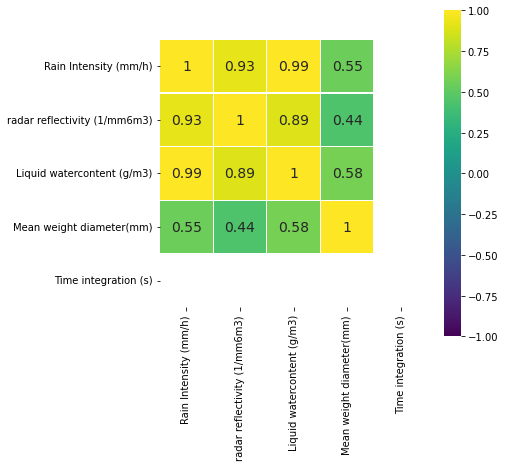

In [171]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);